In [1]:
import sys
import os
import itertools 
module_path = os.path.abspath(os.path.join('../')) 
sys.path.insert(0, module_path)

import pandas as pd

from pathlib import Path
import json
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

import katspace
import katspace.core
import katspace.data
import katspace.plot


import importlib
for mod in ["katspace.core", "katspace.data", "katspace.plot"]:
    importlib.reload(sys.modules[mod])

from katspace.core import DATA_DIR, DRIVE_DIR, SPACE_TYPES, RESULTS_DIR
from katspace.data import chunker, chunk_lengths
from katspace.plot import hist_heatmap as plot_hist_heatmap

import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import numpy as np
import math

RESULTS_DIR_GB = Path(RESULTS_DIR, "predict-286-gutenberg")

Configuration file /Users/katrinrohrbacher/Meine Ablage/aspects-space-dev/katspace_config.json not found in /Users/katrinrohrbacher/Meine Ablage/aspects-space-dev/notebooks


In [2]:
#copied to data.py
def results_from_json(filenames, results_dir): 

  if isinstance(filenames, str):
    filename = filenames
    json_file_path = Path(results_dir, Path(filename).stem + '-result.json')

    if json_file_path.exists():
        with open(json_file_path, 'r', encoding="utf-8") as f:
            json_results = json.load(f)
        return json_results
    else:
        return None
  elif isinstance(filenames, list):
    return {filename : results_from_json(filename, results_dir) for filename in filenames}


def plot_history(years, space_types_dict, normalize = True, total_space = False, cumul = False, plot_no_space = False, smooth_to_next_decade = False):
  fig, ax = plt.subplots(figsize=(10, 6))
  
  y_dict = {}
  types_for_plot = list(SPACE_TYPES)

  if total_space:
     types_for_plot = types_for_plot + ["all_space"]

  for space_type in types_for_plot:
    if (not plot_no_space) and space_type == 'no_space':
      continue
    if normalize: 
      y_dict[space_type] = np.array(space_types_dict[space_type]) / np.array(space_types_dict["total"])
    elif not normalize: 
      y_dict[space_type] = np.array(space_types_dict[space_type])

  if smooth_to_next_decade:
     delta_year = 10
  else:
     delta_year = 15
  ticks = [ year for year in years if year%delta_year==0]
  labels = map(str,map(round,ticks))

  for space_type in y_dict.keys():
    label = space_type
    ax.plot(years, y_dict[space_type], label=label)

  ax.legend()
  ax.set_xlabel("Year")
  ax.set_ylabel("Frequency")
  ax.set_xticks(ticks, labels=labels, rotation=90)

  return fig, ax


def plot_preprocess(results, num_chunks=20, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space"), results_format = "parquet"):
    #ignore files without results
    results = {filename: result for filename, result  in results.items() if result != None}

    #ignore files with fewer than num_chunks sentences
    results = {filename: result for filename, result  in results.items() if len(result) >= num_chunks}

    print(f"Ignoring {len([filename for filename, result  in results.items() if len(result) < num_chunks])} files because they have too few sents")

    if results_format != "parquet":
      labels = {filename: [result["label"] for result in results[filename]] for filename in results.keys()}
    else:
      labels = results

    chunked_labels = {filename: chunker(labels[filename], num_chunks=num_chunks) for filename in labels.keys()}
    chunk_sizes = {filename: [len(chunk) for chunk in chunked_labels[filename]] for filename in labels.keys()}
    chunk_size_zero = [filename for filename in labels.keys() if chunk_sizes[filename] == 0]
    if len(chunk_size_zero) > 0:
      print(f"The followowing files have chunks of size 0: \n {chunk_size_zero}")

    counters = {filename: [Counter(label_chunk) for label_chunk in chunked_labels[filename]] for filename in chunked_labels.keys()}

    def total_sum(counter, sum_sel):
        num = [counter[space_type] for space_type in sum_sel]
        return sum(num)

    # change order of indexing to have space type as outermost index
    count_dict = {space_type: {filename: [counter[space_type] for counter in counters[filename]] for filename in counters.keys()} for space_type in SPACE_TYPES}

    count_dict["all_space"] = {}
    for filename in counters.keys():
      count_dict["all_space"][filename] = [total_sum(counter, sum_sel) for counter in counters[filename]]

    return count_dict, chunk_sizes

def plot_narrative_time(results, chunksize = 50, space_types = ("perceived_space", "action_space", "visual_space", "descriptive_space"),
                        total = False, sum_sel = ("perceived_space", "action_space", "visual_space", "descriptive_space")):
  def chunker(seq, size):
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]


  def total_sum(counter, sum_sel):
    num = [counter[space_type] for space_type in sum_sel]
    return sum(num)

  labels = [result["label"] for result in results]
  chunks = chunker(labels, chunksize)
  num_chunks = len(chunks)
  


  counters = [Counter(chunk) for chunk in chunks]
  # change order of indexing to have space type as outermost index
  count_dict = {space_type : [counter[space_type] for counter in counters] for space_type in space_types}
  count_dict["all_space"] = [total_sum(counter, sum_sel) for counter in counters]

  fig, ax = plt.subplots()
  x = [chunk[0] for chunk in chunker(range(len(labels)), chunksize)]

  for space_type in space_types:
    y = np.array(count_dict[space_type]) / np.array([chunksize]*num_chunks)

    label = space_type

    ax.plot(x, y, label = label)

  if total:
    y = np.array(count_dict["all_space"]) / np.array([chunksize]*num_chunks)

    label = "all_space"
    ax.plot(x, y, label = label)

  ax.legend()
  ax.set_xlabel("Sentences")
  ax.set_ylabel("% Types of setting")
  plt.show()

def plot_p_values_heatmap(res, genres, space_type):

    values = np.round(res[space_type].pvalue, 3)

    fig, ax = plt.subplots(figsize = (10,8))
    im = ax.imshow(values)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(genres)), labels=genres)
    ax.set_yticks(np.arange(len(genres)), labels=genres)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(genres)):
        for j in range(len(genres)):
            if i >= j: 
                text = ax.text(j, i, values[i, j],
                            ha="center", va="center", color="w")
            else: 
                value = res[space_type].statistic[j,i]
                value = np.round(100 * value, 1)
                ax.text(j, i, value, 
                            ha="center", va="center", color="w")

    ax.set_title(space_type)
    plt.show()

## Load df

In [ ]:
gutenberg_df = pd.read_excel(Path(DATA_DIR, "20231216_1_gutenberg_master.xlsx"), index_col = 0)
gutenberg_df

## Descriptives

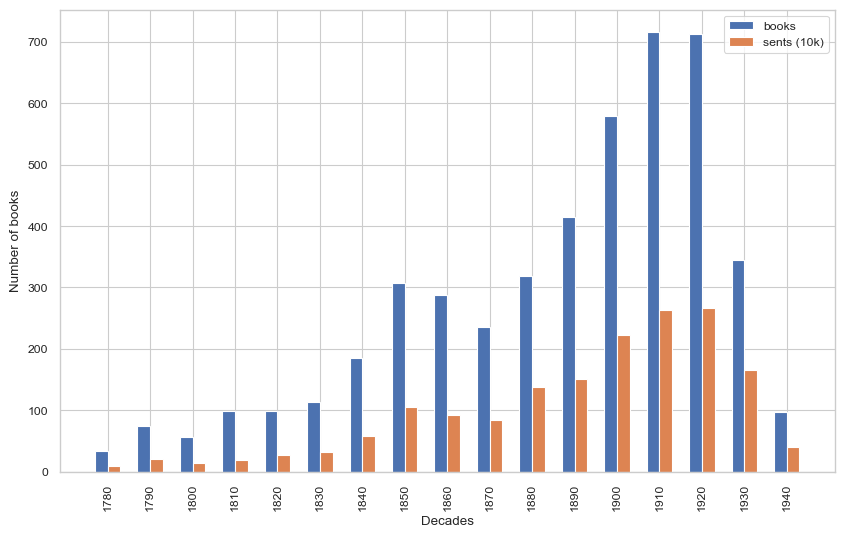

In [4]:
def plot_years(df):  
    df = df.loc[:,["year", "total"]]
    sel = (df["year"] > 1780) & (df["year"] < 1950)
    df = df[sel]
    df.loc[:,'books'] = 1 

    def round_to_decade(y):
        return int(10 * math.floor(y / 10))

    df["year"] = df["year"].apply(round_to_decade)

    df_sums = df.groupby('year').sum()
    df_sums["total"] = df_sums["total"] / 10000

    df_sums.rename(columns = {"total" : "10k_sents", "year" : "decade"}, inplace = True)
    years = df_sums.index.values

    x = [xpos for xpos in range(len(years))]


    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.3


    ax.bar([xpos - width/2 for xpos in x] , df_sums["books"], width, label="books")
    ax.bar([xpos + width/2 for xpos in x], df_sums["10k_sents"], width, label="sents (10k)")
    ax.set_xlabel("Decades")
    ax.set_ylabel("Number of books")
    ax.set_xticks(x, labels=years, rotation = 90)


    _ = ax.legend()

plot_years(gutenberg_df)

In [5]:
genre_dict = {'Historische Kriminalromane und -fälle' : "hist crime", 
              'Historische Romane und Erzählungen' : "hist novels", 
              'Horror' : "horror", 
              'Humor, Satire' : "satire", 
              'Jugendliteratur' : "young adult (YA)", 
              'Krimis, Thriller, Spionage' : "crime", 
              'Märchen, Sagen, Legenden' : "fairy tales", 
              'Phantastische Literatur' : "spec fic", 
              'Romane, Novellen und Erzählungen' : "novels, novellas", 
              'Romanhafte Biographien' : "bio fic", 
              'Science Fiction' : "sci fi", 
              'Spannung und Abenteuer' : "adventure"}

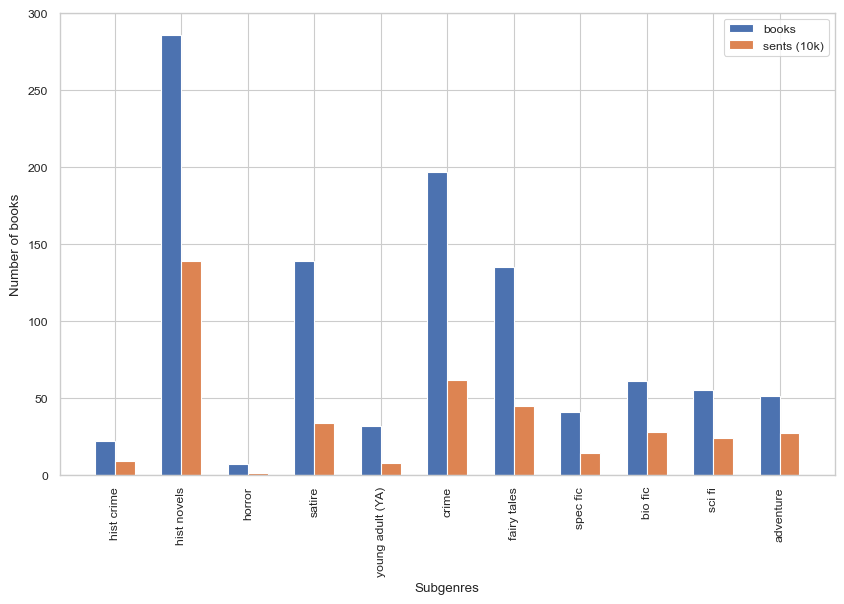

In [6]:
df = gutenberg_df.loc[:,["year", "genre_3", "total"]]
sel = (gutenberg_df["year"] > 1770) & (gutenberg_df["year"] < 1950)
df = df[sel][["genre_3", "total"]]
df.loc[:,'books'] = 1 

df_sums = df.groupby('genre_3').sum()
df_sums["total"] = df_sums["total"] / 10000
df_sums.rename(columns = {"total" : "10k_sents", "year" : "decade"}, inplace = True)

df_sums = df_sums.drop("Romane, Novellen und Erzählungen", axis = 0)

df_sums.index = df_sums.index.map(genre_dict)

x_labels = df_sums.index.values

x = [xpos for xpos in range(len(x_labels))]

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3

ax.bar([xpos - width/2 for xpos in x] , df_sums["books"], width, label="books")
ax.bar([xpos + width/2 for xpos in x], df_sums["10k_sents"], width, label="sents (10k)")
ax.set_xlabel("Subgenres")
ax.set_ylabel("Number of books")
ax.set_xticks(x, labels= x_labels, rotation = 90)

_ = ax.legend()

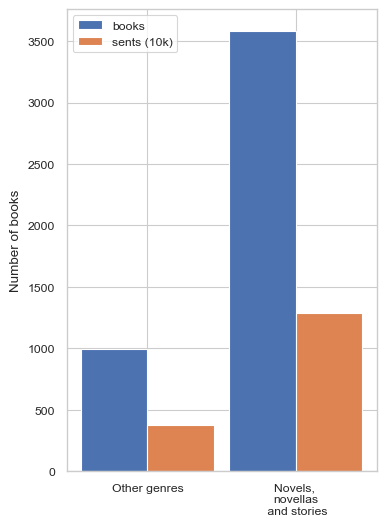

In [7]:
df = gutenberg_df.loc[:,["year", "genre_3", "total"]]
sel = (gutenberg_df["year"] > 1780) & (gutenberg_df["year"] < 1940)
df = df[sel][["genre_3", "total"]]
df.loc[:,'books'] = 1 

group_sel = df["genre_3"] == "Romane, Novellen und Erzählungen"

df_sums = df.groupby(group_sel).sum()

df_sums["total"] = df_sums["total"] / 10000
df_sums.rename(columns = {"total" : "10k_sents", "year" : "decade"}, inplace = True)

x_labels = ["Other genres","Novels, \nnovellas\n and stories"]

x = [xpos for xpos in range(len(x_labels))]

fig, ax = plt.subplots(figsize=(4, 6))

width = 0.45

ax.bar([xpos - width/2 for xpos in x] , df_sums["books"], width, label="books")
ax.bar([xpos + width/2 for xpos in x], df_sums["10k_sents"], width, label="sents (10k)")
#ax.set_xlabel("Genres")
ax.set_ylabel("Number of books")
ax.set_xticks(x, labels=x_labels)

ax.legend(loc = "upper left")

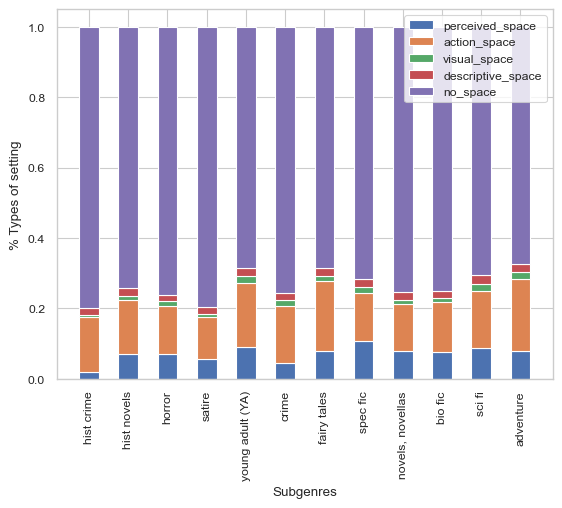

In [8]:
def genre_stackplot(gutenberg_df): 
    cols = ["genre_3"] + list(SPACE_TYPES) + ["total"]
    genre_df = gutenberg_df[cols].groupby("genre_3").sum()
    genre_df.index.names = ["genre"]

    genres = genre_df.index.values
    genres = [genre_dict[genre] for genre in genres]
    space_counts = {
        space_type : genre_df[space_type]  for space_type in SPACE_TYPES            
    }

    norm_space_counts = {
        space_type : genre_df[space_type] / genre_df["total"] for space_type in SPACE_TYPES 
    }
    width = 0.5

    fig, ax = plt.subplots()

    bottom = np.zeros(12)

    for space_type, space_count in norm_space_counts.items():

        #genre = genre_dict[genre]
        p = ax.bar(genres, space_count, width, label=space_type, bottom=bottom)
        bottom += space_count

    #ax.set_title("Number of penguins with above average body mass")
    ax.legend(loc="upper right")
    ax.set_xlabel("Subgenres")
    ax.set_ylabel("% Types of setting")
    
    plt.xticks(rotation=90)
    

    plt.show()

genre_stackplot(gutenberg_df)

In [13]:
gb_small = gutenberg_df.drop(["title", "yearpub", "firstpub", "genre_1", "genre_2", "genre_3", "folder", "type", "publisher", "filename"], axis=1)
sel = (gb_small["year"] > 1780) & (gb_small["year"] < 1940)
gb_small[sel]

,author_first,year,perceived_space,action_space,visual_space,descriptive_space,no_space,total,all_space
author_last,,,,,,,,,
Achleitner,Arthur,1916,124,483,23,27,1066,1723,657
Achleitner,Arthur,1903,126,564,25,32,2713,3460,747
Achleitner,Arthur,1896,127,373,9,27,1431,1967,536
Achleitner,Arthur,1901,155,377,15,37,2030,2614,584
Achleitner,Arthur,1910,1071,1560,59,159,3501,6350,2849
...,...,...,...,...,...,...,...,...,...
Zweig,Arnold,1912,316,218,25,30,2131,2720,589
Zweig,Friderike Maria Burger Winternitz,1919,609,875,86,159,6117,7846,1729
Zweig,Stefan,1922,615,355,27,18,2072,3087,1015


In [14]:
gb_group = gb_small[sel].groupby(["author_last", "author_first"])
gb_authors = gb_group.agg(
    min_year=pd.NamedAgg(column="year", aggfunc="min"),
    max_year=pd.NamedAgg(column="year", aggfunc="max"),
    perveived_space=pd.NamedAgg(column="perceived_space", aggfunc="sum"), 
    action_space=pd.NamedAgg(column="action_space", aggfunc="sum"),
    visual_space=pd.NamedAgg(column="visual_space", aggfunc="sum"),
    descriptive_space=pd.NamedAgg(column="descriptive_space", aggfunc="sum"),
    no_space=pd.NamedAgg(column="no_space", aggfunc="sum"),
    all_space=pd.NamedAgg(column="all_space", aggfunc="sum"),
    total=pd.NamedAgg(column="total", aggfunc="sum"))
gb_authors["num_books"] = gb_group.size()
gb_authors

min_year  max_year  \
author_last           author_first                                            
Achleitner            Arthur                                 1896      1920   
Adler                 Paul                                   1915      1915   
Adlersfeld-Ballestrem Eufemia von                            1890      1927   
Adolph                Karl                                   1908      1924   
Ahlborn               Luise                                  1887      1887   
...                                                           ...       ...   
Zur Mühlen            Hermynia                               1922      1922   
Zweig                 Arnold                                 1912      1912   
                      Friderike Maria Burger Winternitz      1919      1919   
                      Stefan                                 1904      1939   
Zznafer               Leo                                    1835      1835   

                                                         perveived_space  \
author_last           author_first                                         
Achleitner            Arthur                                        3044   
Adler                 Paul                                            75   
Adlersfeld-Ballestrem Eufemia von                                   1661   
Adolph                Karl                                           771   
Ahlborn               Luise                                          203   
...                                                                  ...   
Zur Mühlen            Hermynia                                       305   
Zweig                 Arnold                                         316   
                      Friderike Maria Burger Winternitz              609   
                      Stefan                                        3306   
Zznafer               Leo                                             84   

                                                         action_space  \
author_last           author_first                                      
Achleitner            Arthur                                     7354   
Adler                 Paul                                         87   
Adlersfeld-Ballestrem Eufemia von                                3842   
Adolph                Karl                                       1613   
Ahlborn               Luise                                       594   
...                                                               ...   
Zur Mühlen            Hermynia                                    256   
Zweig                 Arnold                                      218   
                      Friderike Maria Burger Winternitz           875   
                      Stefan                                     2684   
Zznafer               Leo                                         361   

                                                         visual_space  \
author_last           author_first                                      
Achleitner            Arthur                                      271   
Adler                 Paul                                          6   
Adlersfeld-Ballestrem Eufemia von                                 349   
Adolph                Karl                                        113   
Ahlborn               Luise                                        58   
...                                                               ...   
Zur Mühlen            Hermynia                                     30   
Zweig                 Arnold                                       25   
                      Friderike Maria Burger Winternitz            86   
                      Stefan                                      200   
Zznafer               Leo                                          16   

                                                         descriptive_space  \
author_last           author_first                            

## Plot History

In [15]:
filenames = gutenberg_df["filename"]
filenames = list(filenames)

results = results_from_json(filenames, results_dir=Path(RESULTS_DIR_GB))

In [18]:
count_dict, chunk_sizes = plot_preprocess(results, results_format = "json")

Ignoring 0 files because they have too few sents


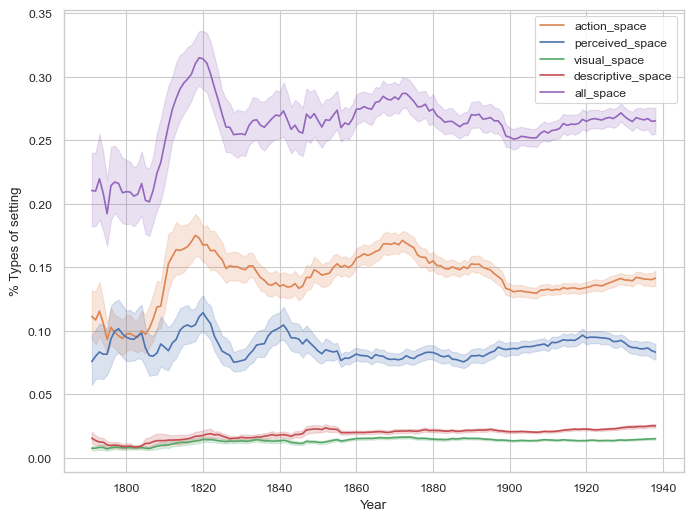

In [19]:
def plot_smooth_space(df):
    gutenberg_df = df
    sel = (df["year"] > 1780) & (df["year"] < 1940)
    plot_df = katspace.plot.calculate_ratios(df[sel])
    smooth_df = katspace.plot.smooth_df(plot_df[["action_space_rt", "perceived_space_rt", "visual_space_rt", "descriptive_space_rt", "all_space_rt"]])

    sns.set_context("paper")
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(8, 6))

    lines = sns.lineplot(smooth_df, palette=["#dd8452", "#4c72b0", "#55a868", "#c44e52", "#9467bd"], dashes=False)
    handles, labels = lines.get_legend_handles_labels()
    custom_labels = ['action_space', 'perceived_space', 'visual_space', 'descriptive_space', 'all_space']
    
   
    plt.legend(handles=handles[:5], labels=custom_labels)
    plt.ylabel("% Types of setting")
    plt.xlabel("Year")

plot_smooth_space(gutenberg_df)

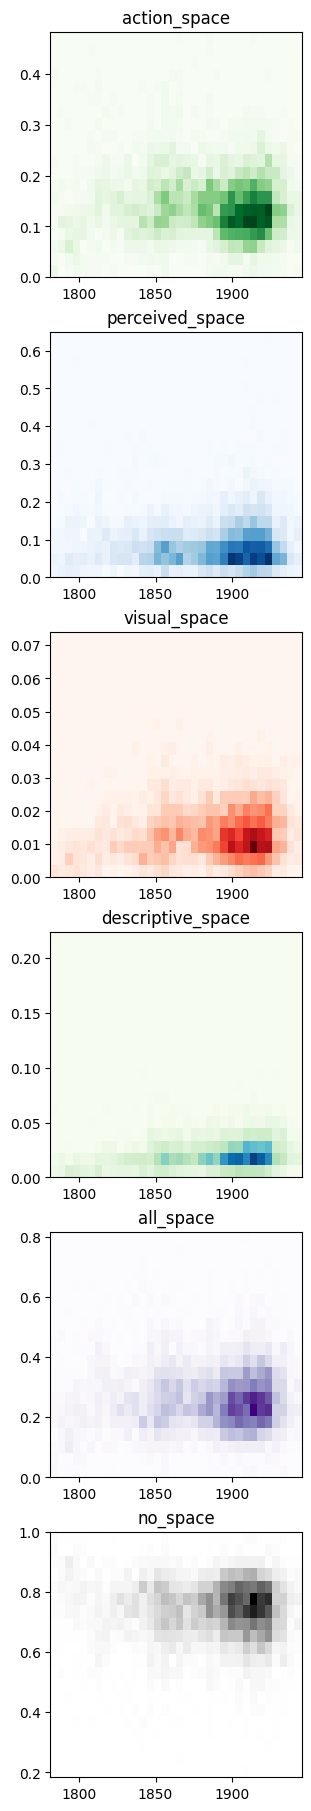

In [9]:
sel = (gutenberg_df["year"] > 1780) & (gutenberg_df["year"] < 1950)
plot_hist_heatmap(gutenberg_df[sel])

## Random Sample

In [20]:
from random import randint, seed
import time

seed(round(time.time()*1000))

def rand_books_from_df(size, df):
    idx = df.index.values
    max = len(gutenberg_df.index.values)
    idx_sel = [idx[randint(0, max)] for _ in range(size)]
    sel = df.index.isin(idx_sel)
    return df[sel]

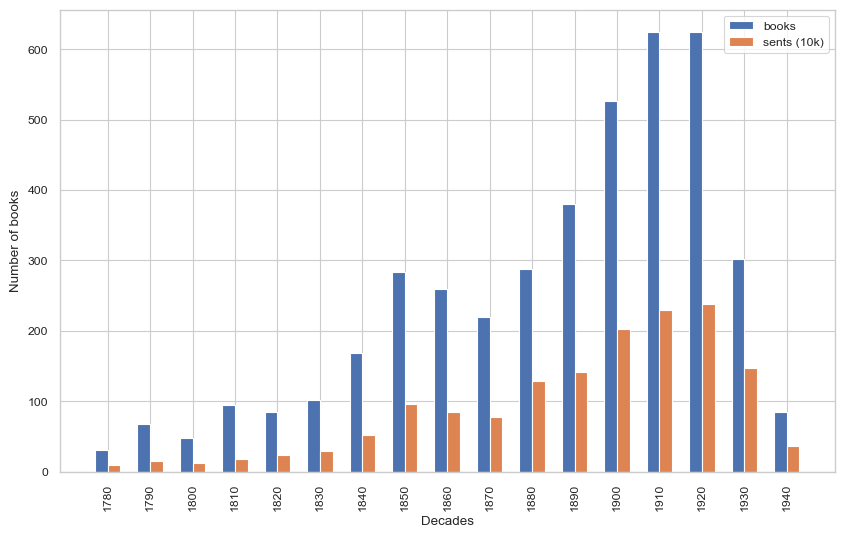

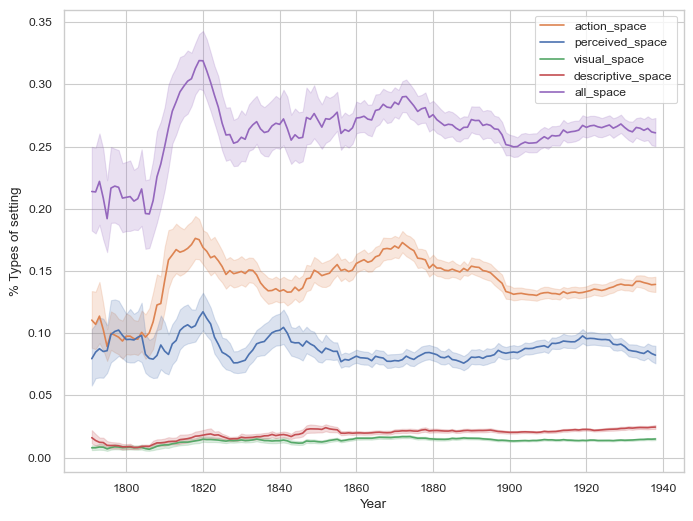

In [21]:
df = gutenberg_df
idx = df.index.values
max = len(gutenberg_df.index.values)
idx_sel = []
while (len(idx_sel) < 719):
    idx_sel.append(idx[randint(0, max-1)])
    idx_sel = list(set(idx_sel))
sel = df.index.isin(idx_sel)
df = df[sel]
plot_years(df)
plot_smooth_space(df)

# Tukey test

In [22]:
from scipy.stats import tukey_hsd

def prep_tukey_kramer(gutenberg_df): 
    cols = ["genre_3"] + list(SPACE_TYPES) + ["total"]
    genre_df = gutenberg_df[cols].groupby("genre_3").sum()
    genre_df.index.names = ["genre"]

    genres = genre_df.index.values
    dic = { space_type: {} for space_type in SPACE_TYPES} 
    for space_type, genre in itertools.product(SPACE_TYPES, genres):
        positive = genre_df.loc[genre, space_type] 
        negative = genre_df.loc[genre, "total"] - positive
        group_samples = ([1] * positive) + ([0] * negative)
        genre_e = genre_dict[genre]
        dic[space_type][genre_e] = group_samples
    return dic 

def tukey_kramer(dic, space_types):
    res_dict = {}
    for space_type in space_types:
        groups = list(dic[space_type].values())
        res = tukey_hsd(*groups)
        print("\n\n\n")
        print(space_type)
        print(res)
        res_dict[space_type] = res
    return res_dict

dic = prep_tukey_kramer(gutenberg_df)

In [23]:
res = tukey_kramer(dic, SPACE_TYPES)
genres = dic["action_space"].keys()





perceived_space
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.051     0.000    -0.054    -0.049
 (0 - 2)     -0.050     0.000    -0.058    -0.041
 (0 - 3)     -0.035     0.000    -0.038    -0.032
 (0 - 4)     -0.069     0.000    -0.074    -0.065
 (0 - 5)     -0.026     0.000    -0.029    -0.023
 (0 - 6)     -0.060     0.000    -0.063    -0.057
 (0 - 7)     -0.089     0.000    -0.092    -0.085
 (0 - 8)     -0.060     0.000    -0.063    -0.057
 (0 - 9)     -0.056     0.000    -0.059    -0.053
 (0 - 10)     -0.069     0.000    -0.072    -0.065
 (0 - 11)     -0.060     0.000    -0.063    -0.056
 (1 - 0)      0.051     0.000     0.049     0.054
 (1 - 2)      0.002     1.000    -0.006     0.010
 (1 - 3)      0.016     0.000     0.015     0.018
 (1 - 4)     -0.018     0.000    -0.021    -0.015
 (1 - 5)      0.025     0.000     0.024     0.027
 (1 - 6)     -0.009     0.000    -0.010    -0.007
 (1 - 7)  

In [25]:
cols = ["genre_3"] + list(SPACE_TYPES) + ["total"]
#genre_df = gutenberg_df[cols]
genre_df = gutenberg_df[cols].rename(columns = {"genre_3" : "Genre"}).groupby("Genre").sum()
genre_df.index = genre_df.index.map(genre_dict)

genre_df


,perceived_space,action_space,visual_space,descriptive_space,no_space,total
Genre,,,,,,
hist crime,1849,14362,620,1878,73687,92396
hist novels,99344,211613,17294,30638,1030526,1389415
horror,827,1621,183,209,9034,11874
satire,19345,42235,3264,6842,278668,350354
young adult (YA),6833,13968,1419,1808,52356,76384
crime,28226,98192,10098,13275,463482,613273
fairy tales,36599,90202,6011,10542,312206,455560
spec fic,15351,19187,2405,2919,101441,141303
"novels, novellas",1073804,1766460,182247,279556,10124218,13426285


In [26]:
means_df = genre_df.iloc[:,:-1].div(genre_df.total, axis=0)
means_df.to_excel(Path(DATA_DIR, "genre_means_tukey.xlsx"))
means_df.iloc[:,:] = means_df.iloc[:,:].mul(100).round(2)
means_df

,perceived_space,action_space,visual_space,descriptive_space,no_space
Genre,,,,,
hist crime,2.00,15.54,0.67,2.03,79.75
hist novels,7.15,15.23,1.24,2.21,74.17
horror,6.96,13.65,1.54,1.76,76.08
satire,5.52,12.05,0.93,1.95,79.54
young adult (YA),8.95,18.29,1.86,2.37,68.54
crime,4.60,16.01,1.65,2.16,75.58
fairy tales,8.03,19.80,1.32,2.31,68.53
spec fic,10.86,13.58,1.70,2.07,71.79
"novels, novellas",8.00,13.16,1.36,2.08,75.41


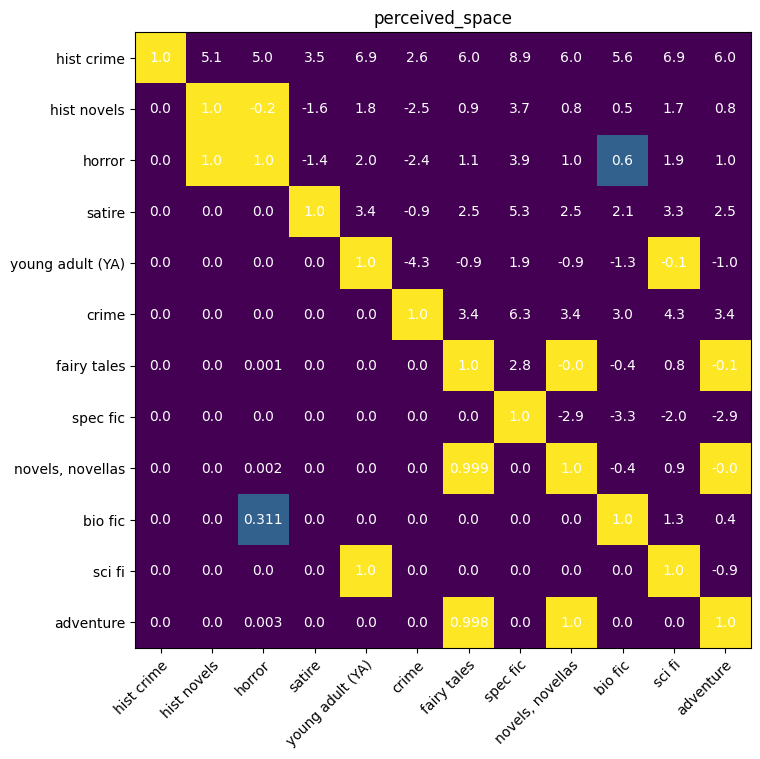

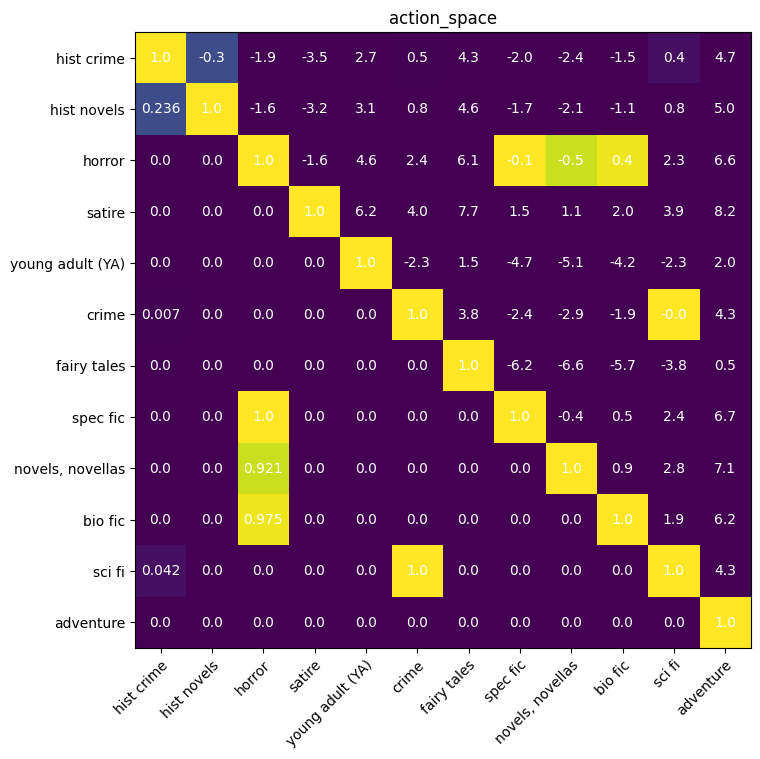

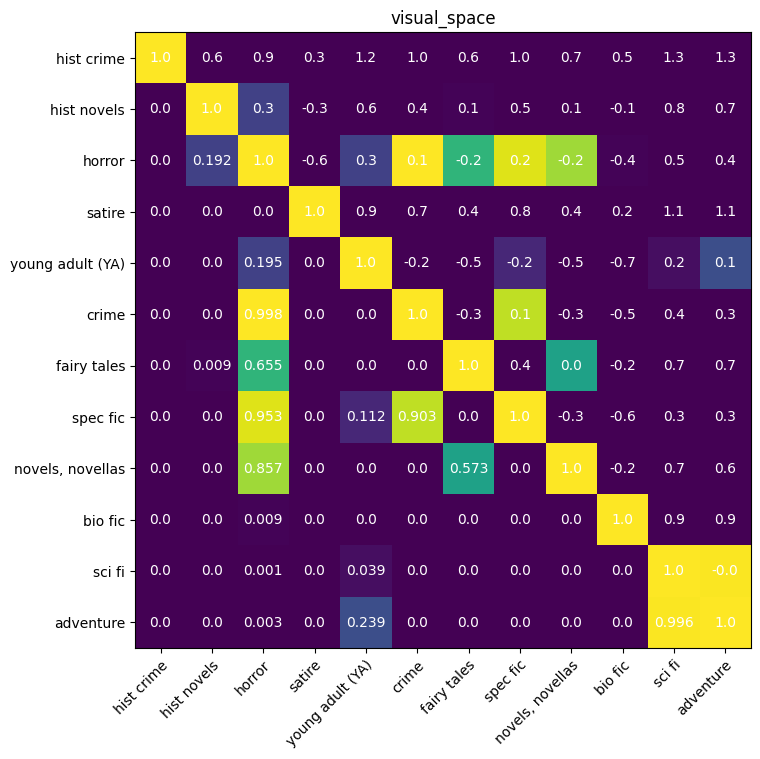

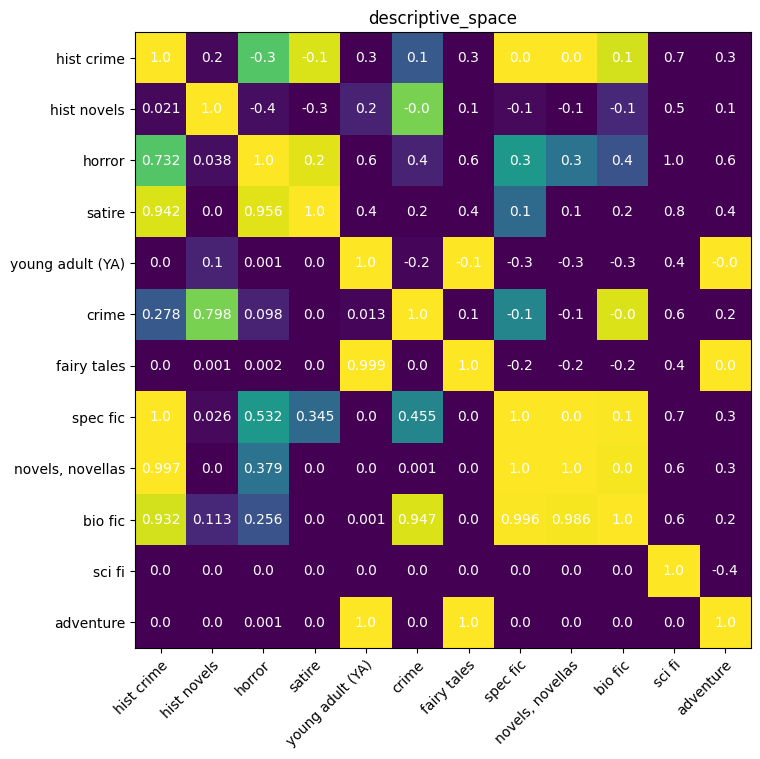

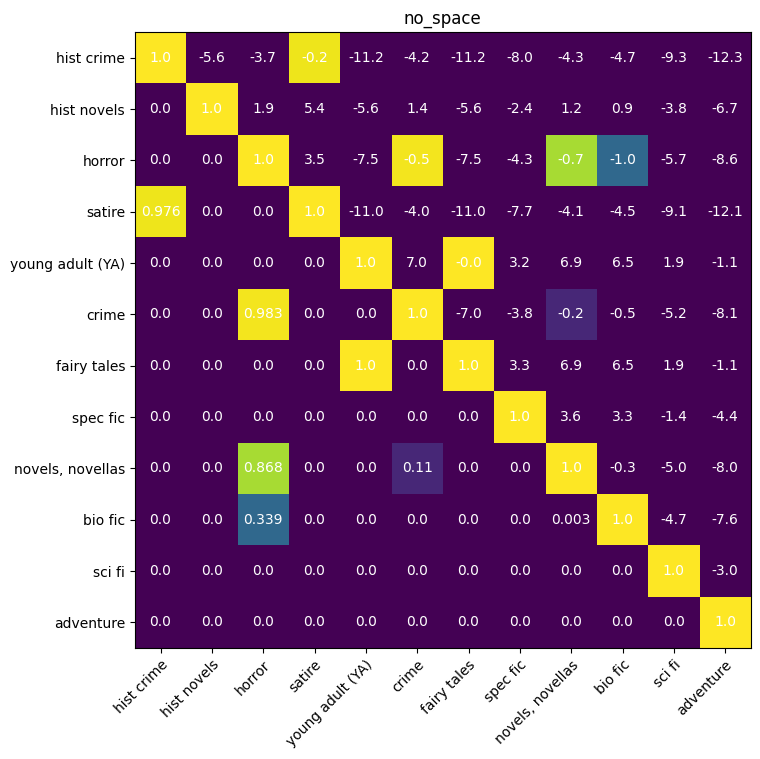

In [29]:
sns.reset_orig()

for space_type in SPACE_TYPES: 
    plot_p_values_heatmap(res, genres, space_type)

## Plot narrative time individual books

In [ ]:
filenames = gutenberg_df["filename"]
filenames = list(filenames)
filenames

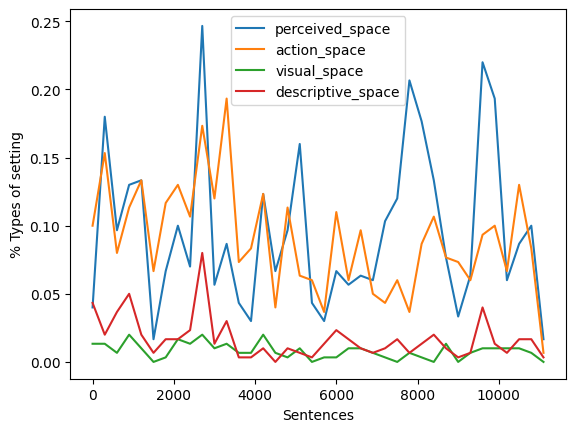

In [31]:
results_gagern = results_from_json("Friedrich_von_Gagern_-_Die_Straße.txt", results_dir = Path(RESULTS_DIR_GB))
plot_narrative_time(results_gagern, 300, total = False)